# Задача 3

Дополним наш анализ ещё более интересными расчётами — вычислим все те же метрики, но для каждого дня будем учитывать накопленную выручку и все имеющиеся на текущий момент данные о числе пользователей и заказов. Таким образом, получим динамический ARPU, ARPPU и AOV и сможем проследить, как он менялся на протяжении времени с учётом поступающих нам данных.

Задание:

По таблицам orders и user_actions для каждого дня рассчитайте следующие показатели:

1. Накопленную выручку на пользователя (Running ARPU).
2. Накопленную выручку на платящего пользователя (Running ARPPU).
3. Накопленную выручку с заказа, или средний чек (Running AOV).
Колонки с показателями назовите соответственно running_arpu, running_arppu, running_aov. Колонку с датами назовите date. 

При расчёте всех показателей округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты. 

Поля в результирующей таблице: date, running_arpu, running_arppu, running_aov

```sql
with revenue_table AS (
  SELECT
    date,
    sum(price) AS revenue
  FROM
    (
      SELECT
        unnest_query.date,
        unnest_query.product_id,
        products.price AS price
      FROM
        (
          SELECT
            order_id,
            creation_time :: date AS date,
            unnest(product_ids) AS product_id
          FROM
            orders
        ) AS unnest_query
        JOIN products using (product_id)
      WHERE
        unnest_query.order_id NOT in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
    ) AS subq
  GROUP BY
    1
),
new_us AS (
  SELECT
    ua.time :: date AS date,
    count(distinct ua.user_id) AS new_users
  FROM
    user_actions ua
  WHERE
    (ua.time :: date, ua.user_id) in (
      SELECT
        min(time :: date),
        user_id
      FROM
        user_actions
      GROUP BY
        user_id
    )
  GROUP BY
    1
),
total_new_users AS (
  SELECT
    *,
    (
      sum(new_users) over(
        ORDER BY
          date
      )
    ) :: int AS total_users
  FROM
    new_us
  ORDER BY
    date
),
paying_users_table AS (
  SELECT
    time :: date AS date,
    count(distinct user_id) AS paying_users
  FROM
    user_actions
  WHERE
    order_id NOT in (
      SELECT
        order_id
      FROM
        user_actions
      WHERE
        action = 'cancel_order'
    )
    AND (user_id, time :: date) in (
      SELECT
        user_id,
        min(time :: date)
      FROM
        user_actions
      WHERE
        order_id NOT in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
      GROUP BY
        1
    )
  GROUP BY
    1
),
orders_table AS (
  SELECT
    creation_time :: date AS date,
    count(distinct order_id) AS act_orders
  FROM
    orders
  WHERE
    order_id NOT in (
      SELECT
        order_id
      FROM
        user_actions
      WHERE
        action = 'cancel_order'
    )
  GROUP BY
    1
)

SELECT
  date,
  round(
    sum(revenue) over(
      ORDER BY
        date
    ) / total_users :: decimal,
    2
  ) AS running_arpu,
  round(
    sum(revenue) over(
      ORDER BY
        date
    ) / (
      sum(paying_users) over(
        ORDER BY
          date
      )
    ) :: decimal,
    2
  ) AS running_arppu,
  round(
    sum(revenue) over(
      ORDER BY
        date
    ) / (
      sum(act_orders) over(
        ORDER BY
          date
      )
    ) :: decimal,
    2
  ) AS running_aov
FROM
  revenue_table
  JOIN total_new_users using (date)
  JOIN paying_users_table using (date)
  JOIN orders_table using (date)
ORDER BY
  1
```

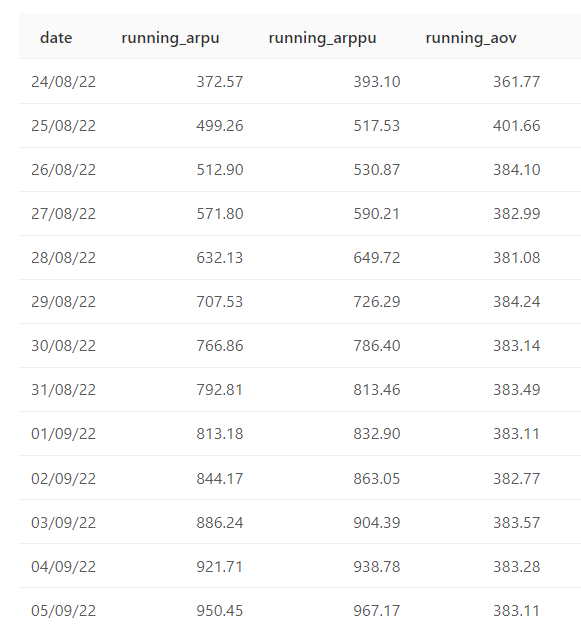

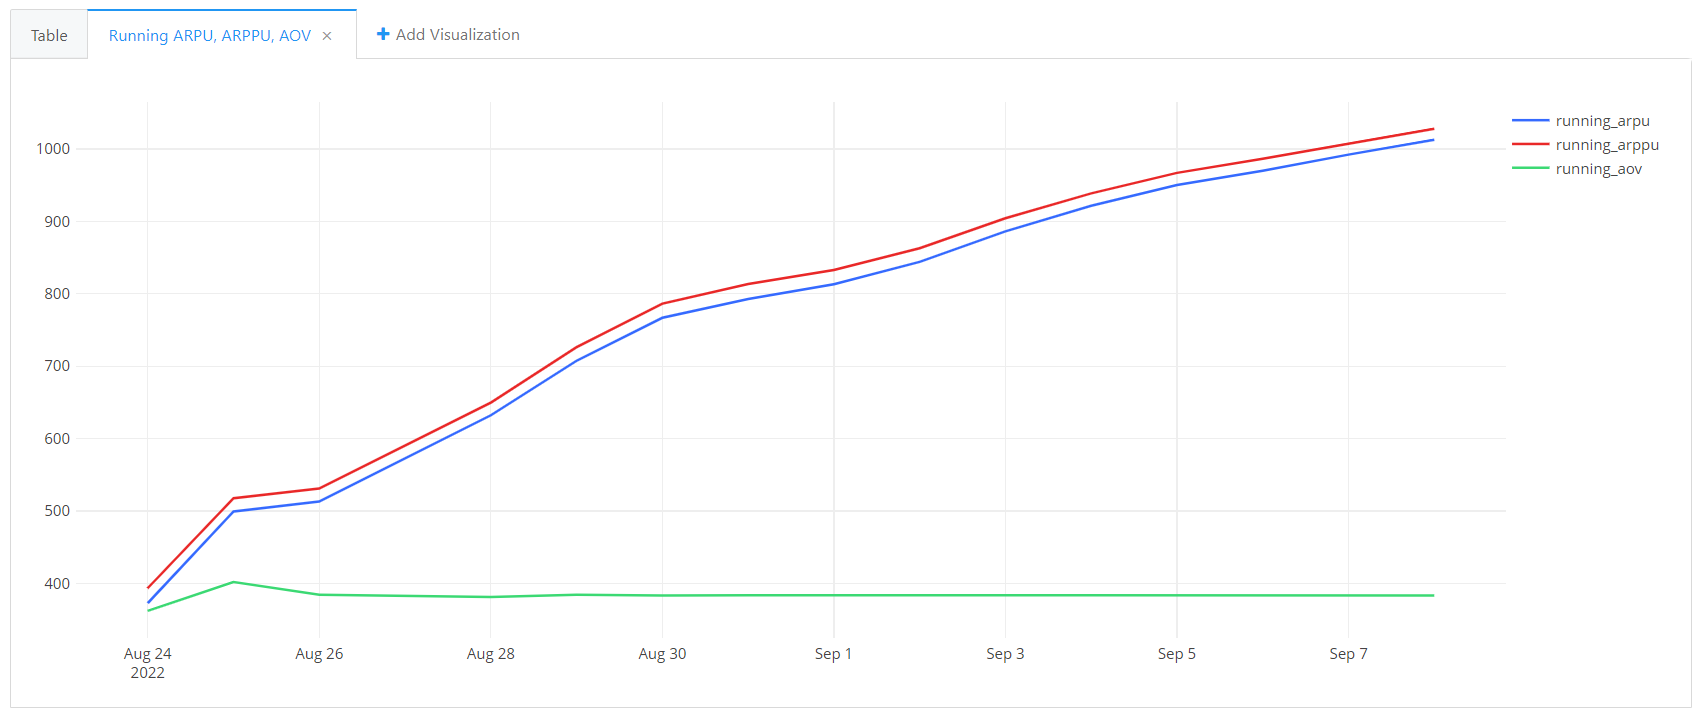